In [11]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

train_dir = r"/home/gokul/Projects/Face-Emotion-Recognition-CNN/data/train"

In [13]:
import os
print(os.path.exists(train_dir))
print(os.listdir(train_dir))


True
['surprise', 'neutral', 'angry', 'happy', 'disgust', 'fear', 'sad']


In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=32,     # ✅ safe batch size
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [15]:
labels = train_gen.classes
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}


In [16]:
model = Sequential([

    # Block 1
    Conv2D(32, (3,3), activation="relu", input_shape=(48,48,1), padding="same"),
    BatchNormalization(),
    Conv2D(32, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Fully Connected
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation="softmax")
])

/home/gokul/ml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758463469.877495   19369 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [18]:
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

In [21]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import GPUtil
import time

class GPUUsageCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            print(f"Epoch {epoch+1} GPU {gpu.id} - Memory Used: {gpu.memoryUsed}MB / {gpu.memoryTotal}MB, Load: {gpu.load*100:.1f}%")

# Use it in model.fit
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, GPUUsageCallback()]
)


Epoch 1/50
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1301 - loss: 1.8340Epoch 1 GPU 0 - Memory Used: 3641.0MB / 6141.0MB, Load: 2.0%
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1364 - loss: 1.8372 - val_accuracy: 0.1900 - val_loss: 1.7890 - learning_rate: 5.0000e-04
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1548 - loss: 1.8340Epoch 2 GPU 0 - Memory Used: 3641.0MB / 6141.0MB, Load: 41.0%
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1589 - loss: 1.8229 - val_accuracy: 0.2163 - val_loss: 1.7867 - learning_rate: 5.0000e-04
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1743 - loss: 1.8120Epoch 3 GPU 0 - Memory Used: 3641.0MB / 6141.0MB, Load: 38.0%
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.1817 - loss: 1.8074 - val_accuracy: 0.1907 - val_loss: 1.7795 - learning_rate: 5.0000e-04
Epoch 4/50
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1788 - loss: 1.7812Epoch 4 GPU 0 - Memory Used: 3

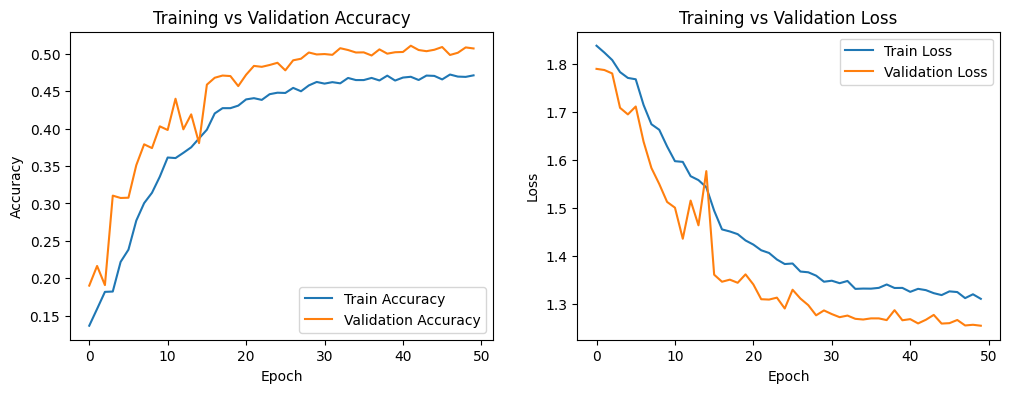

In [22]:
import matplotlib.pyplot as plt

# Extract history values
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax[0].plot(train_acc, label='Train Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].set_title('Training vs Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')

# Loss plot
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_title('Training vs Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')

plt.show()


In [ ]:
model.save("face_emotion_model.h5")
print("✅ Training complete. Model saved as face_emotion_model.h5")


✅ Training complete. Model saved as face_emotion_model.h5
